In [4]:
# Install tensorflow if not already installed
!pip install -q tensorflow matplotlib

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import time
import numpy as np

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf

def rgb_to_grayscale(image):
    gray_image = tf.image.rgb_to_grayscale(image)
    gray_image = tf.image.grayscale_to_rgb(gray_image)  # Keep 3 channels for model compatibility
    return gray_image

def normalize(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    return input_image, target_image

def preprocess(image):
    image = tf.image.resize(image, [256, 256])
    input_image = rgb_to_grayscale(image)
    target_image = image
    input_image, target_image = normalize(input_image, target_image)
    return input_image, target_image

# Load the dataset
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

# Prepare dataset: shuffle, take 200 samples, batch size 4
train_ds = dataset['train'].map(lambda img, label: preprocess(img))
train_ds = train_ds.shuffle(1000).take(200).batch(4)

# Quick preview of input and target shapes
for input_img, target_img in train_ds.take(1):
    print("Input (grayscale) shape:", input_img.shape)
    print("Target (color) shape:", target_img.shape)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.EPJIJ9_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


I0000 00:00:1754975903.911958      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754975903.912614      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Input (grayscale) shape: (4, 256, 256, 3)
Target (color) shape: (4, 256, 256, 3)


In [6]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),                        # (bs, 64, 64, 128)
        downsample(256, 4),                        # (bs, 32, 32, 256)
        downsample(512, 4),                        # (bs, 16, 16, 512)
        downsample(512, 4),                        # (bs, 8, 8, 512)
        downsample(512, 4),                        # (bs, 4, 4, 512)
        downsample(512, 4),                        # (bs, 2, 2, 512)
        downsample(512, 4),                        # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),     # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),     # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),     # (bs, 8, 8, 1024)
        upsample(512, 4),                         # (bs, 16, 16, 1024)
        upsample(256, 4),                         # (bs, 32, 32, 512)
        upsample(128, 4),                         # (bs, 64, 64, 256)
        upsample(64, 4),                          # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
generator.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [7]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.concatenate([inp, tar])  # Condition on input image

    down1 = downsample(64, 4, apply_batchnorm=False)(x)   # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)                     # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)                     # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)             # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)       # (bs, 31, 31, 512)

    batchnorm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)        # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
discriminator.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      6,144 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │    525,312 │ sequential_16[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_17[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_11[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [9]:
# Build models by running one batch through them before training
for example_input, example_target in train_ds.take(1):
    _ = generator(example_input)
    _ = discriminator([example_input, example_target])


In [10]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)  # L1 loss weighted by 100
    return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [11]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [14]:
import time

EPOCHS = 3

def fit(train_ds, epochs):
    for epoch in range(epochs):
        start = time.time()
        print(f"Starting epoch {epoch + 1}...")

        for step, (input_image, target) in enumerate(train_ds):
            gen_loss, disc_loss = train_step(input_image, target)
            if step % 50 == 0:
                print(f"  Step {step}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")

        print(f'Epoch {epoch + 1}/{epochs} completed, Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}, Time: {time.time() - start:.2f}s\n')

fit(train_ds, EPOCHS)


Starting epoch 1...
  Step 0, Gen Loss: 17.0582, Disc Loss: 1.0549
Epoch 1/3 completed, Generator Loss: 20.3983, Discriminator Loss: 0.3660, Time: 11.83s

Starting epoch 2...
  Step 0, Gen Loss: 22.3216, Disc Loss: 0.5122
Epoch 2/3 completed, Generator Loss: 15.3656, Discriminator Loss: 0.8340, Time: 11.97s

Starting epoch 3...
  Step 0, Gen Loss: 17.8036, Disc Loss: 0.6471
Epoch 3/3 completed, Generator Loss: 19.3183, Discriminator Loss: 0.7765, Time: 12.25s



In [19]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5 + 0.5))  # scale from [-1,1] to [0,1]
        plt.axis('off')
    plt.show()


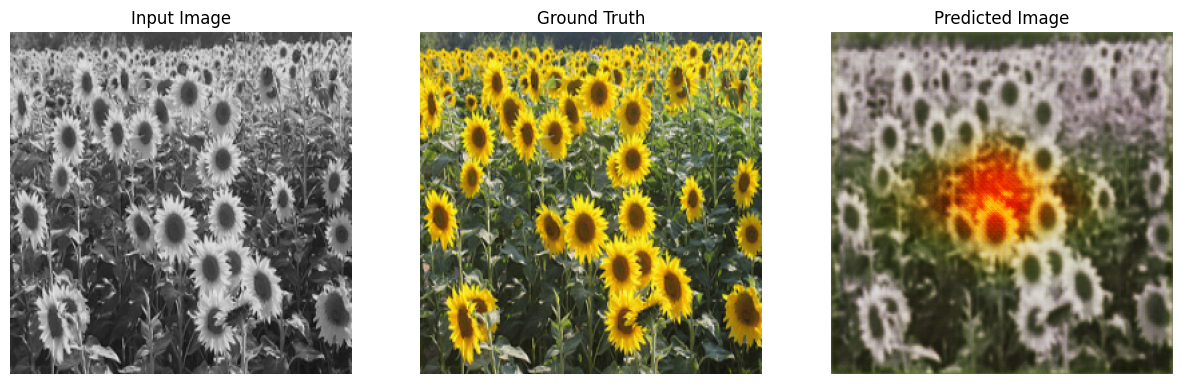

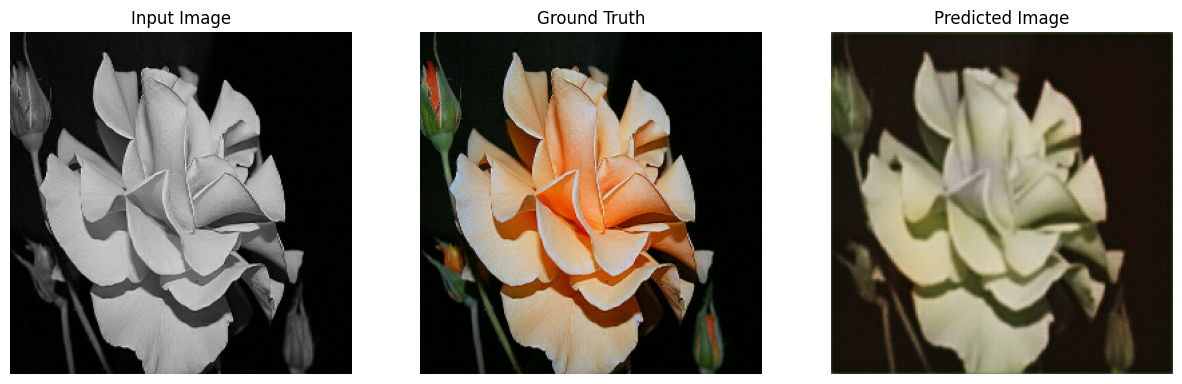

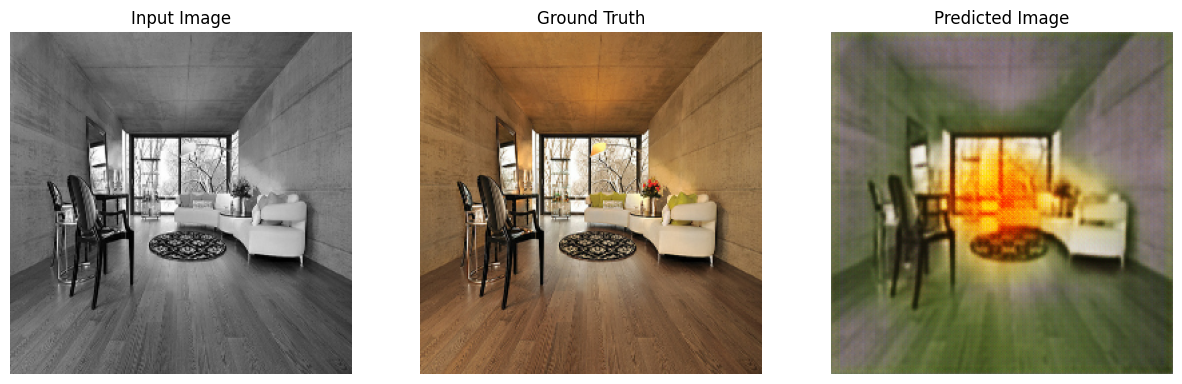

In [21]:
for example_input, example_target in train_ds.take(3):
    generate_images(generator, example_input, example_target)


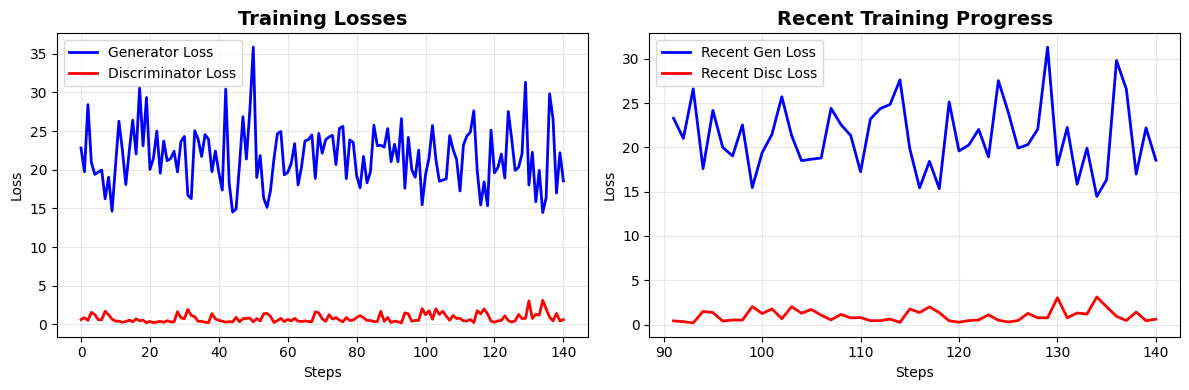

Step 40: Gen Loss = 18.5583, Disc Loss = 0.6074


In [25]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

# Add this to track losses
gen_losses = []
disc_losses = []
steps = []

def plot_losses():
    clear_output(wait=True)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(steps, gen_losses, 'b-', label='Generator Loss', linewidth=2)
    plt.plot(steps, disc_losses, 'r-', label='Discriminator Loss', linewidth=2)
    plt.title('Training Losses', fontsize=14, fontweight='bold')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    if len(gen_losses) > 10:
        # Show recent trend
        recent_gen = gen_losses[-50:]
        recent_disc = disc_losses[-50:]
        recent_steps = steps[-50:]
        plt.plot(recent_steps, recent_gen, 'b-', label='Recent Gen Loss', linewidth=2)
        plt.plot(recent_steps, recent_disc, 'r-', label='Recent Disc Loss', linewidth=2)
        plt.title('Recent Training Progress', fontsize=14, fontweight='bold')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Modified training step to track losses
step_count = 0

@tf.function
def train_step_with_tracking(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Enhanced training with live plotting
def fit_with_live_plots(train_ds, epochs):
    global step_count
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        for step, (input_image, target) in enumerate(train_ds):
            gen_loss, disc_loss = train_step_with_tracking(input_image, target)
            
            # Track losses
            gen_losses.append(float(gen_loss))
            disc_losses.append(float(disc_loss))
            steps.append(step_count)
            step_count += 1
            
            # Plot every 20 steps
            if step % 20 == 0:
                plot_losses()
                print(f"Step {step}: Gen Loss = {gen_loss:.4f}, Disc Loss = {disc_loss:.4f}")

# Use this instead of your original fit function
fit_with_live_plots(train_ds, EPOCHS)

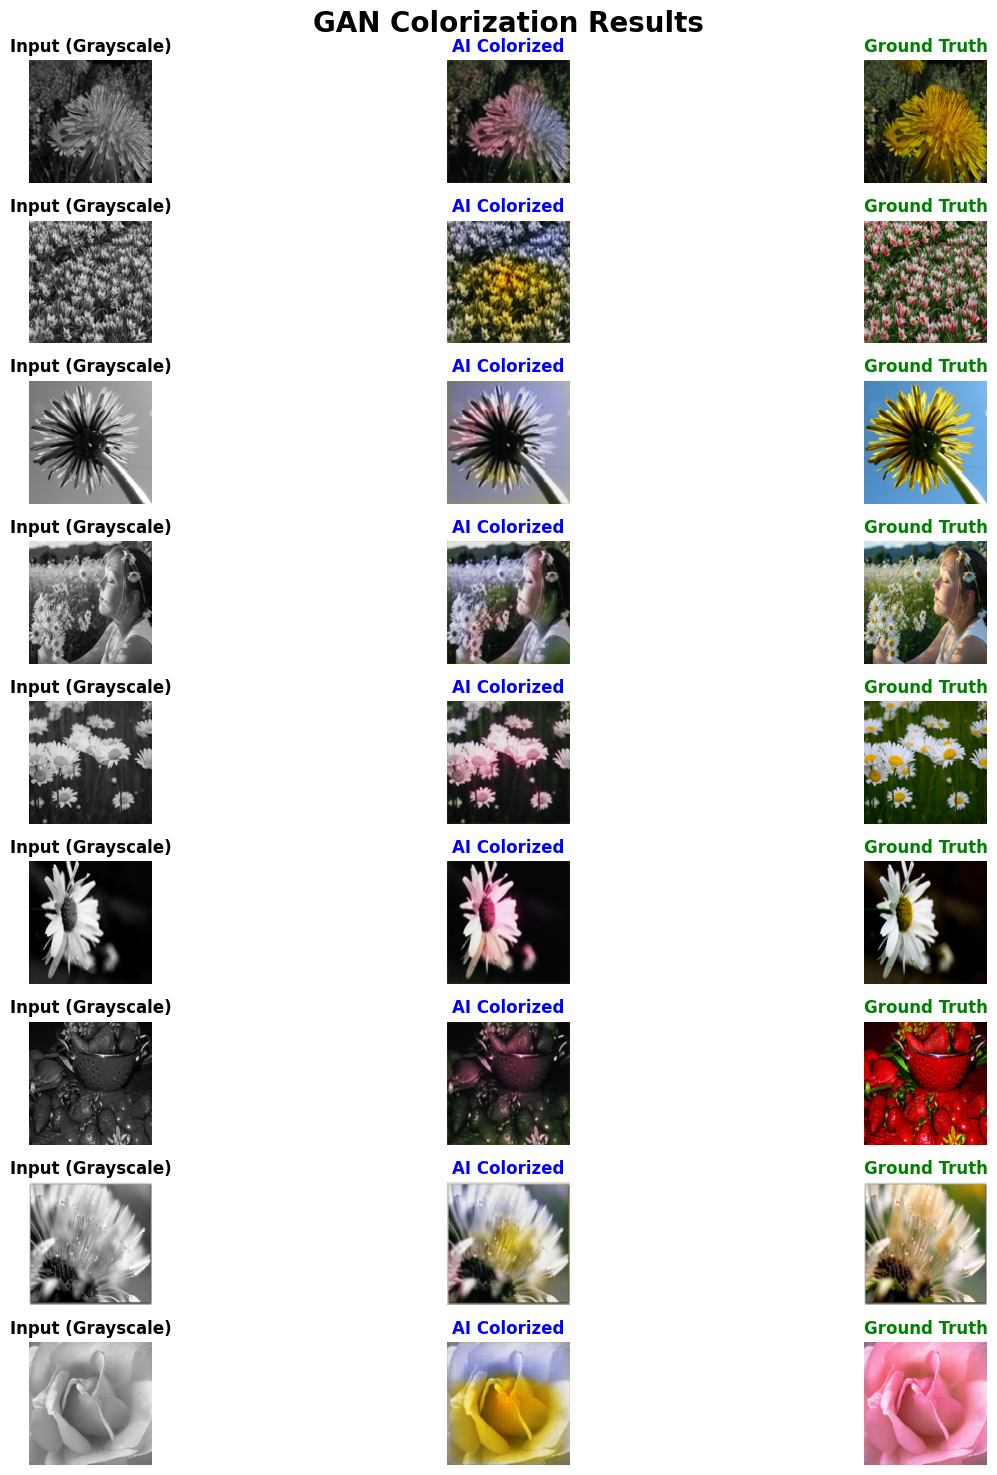

In [26]:
def create_comparison_grid(num_samples=9):
    plt.figure(figsize=(15, 15))
    
    for i, (input_image, target) in enumerate(train_ds.take(num_samples)):
        if i >= num_samples:
            break
            
        prediction = generator(input_image, training=False)
        
        # Input (grayscale)
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow((input_image[0] * 0.5 + 0.5))
        plt.title('Input (Grayscale)', fontweight='bold')
        plt.axis('off')
        
        # Generated (colorized)
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow((prediction[0] * 0.5 + 0.5))
        plt.title('AI Colorized', fontweight='bold', color='blue')
        plt.axis('off')
        
        # Ground truth
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow((target[0] * 0.5 + 0.5))
        plt.title('Ground Truth', fontweight='bold', color='green')
        plt.axis('off')
    
    plt.suptitle('GAN Colorization Results', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run after training
create_comparison_grid()

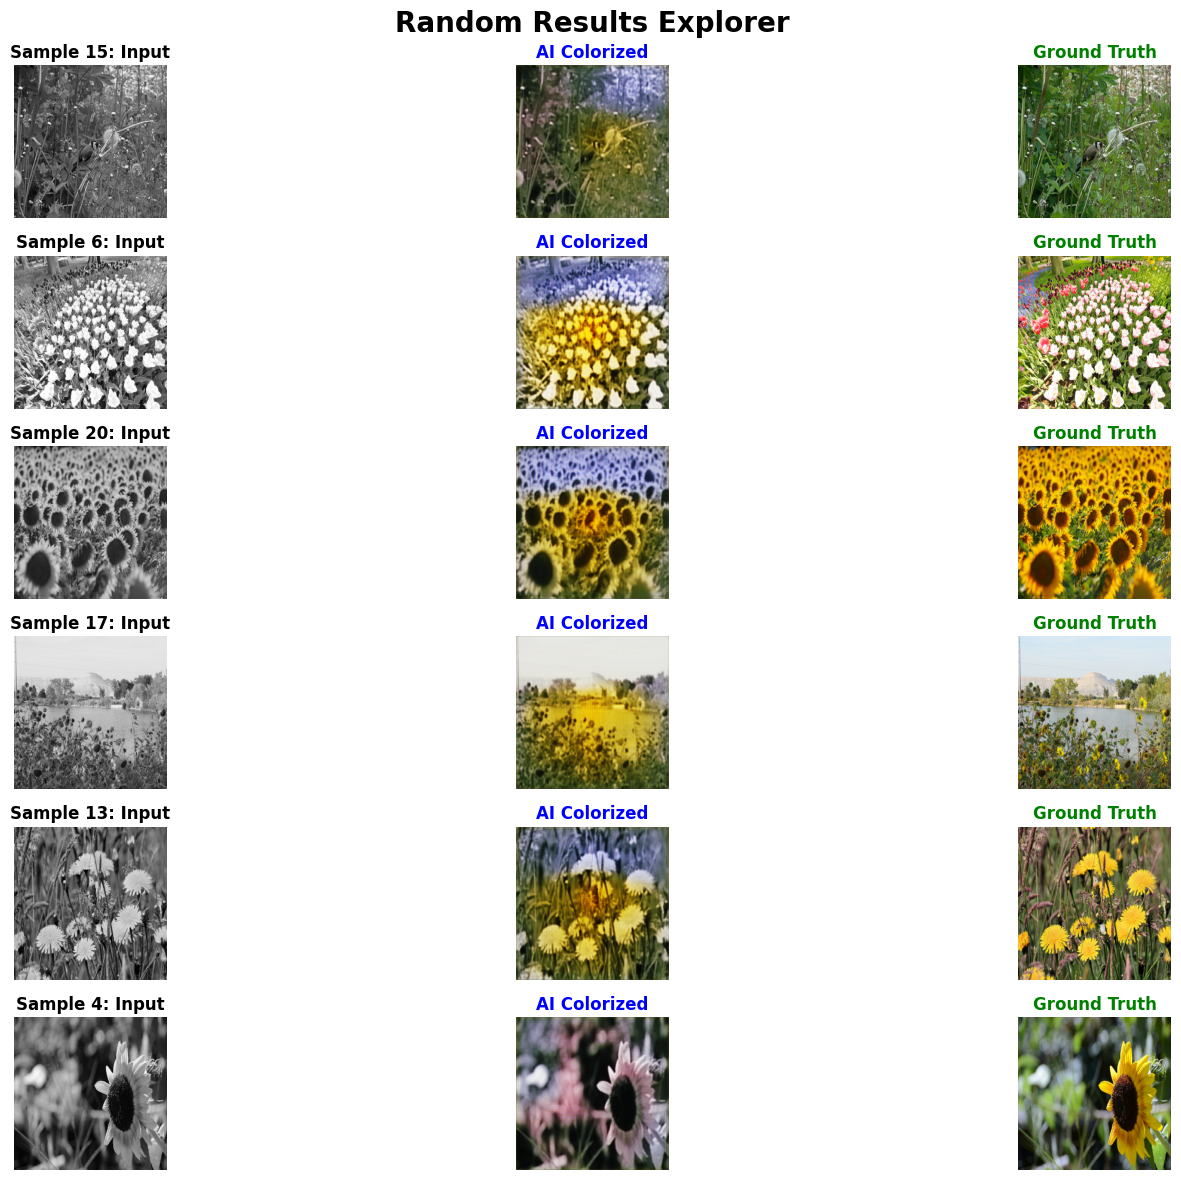

In [28]:
def explore_results_interactive():
    # Create multiple result samples
    results = []
    for i, (input_img, target_img) in enumerate(train_ds.take(20)):
        prediction = generator(input_img, training=False)
        results.append((input_img[0], prediction[0], target_img[0]))
    
    # Display random samples
    import random
    sample_indices = random.sample(range(len(results)), 6)
    
    plt.figure(figsize=(18, 12))
    
    for i, idx in enumerate(sample_indices):
        input_img, pred_img, target_img = results[idx]
        
        # Input
        plt.subplot(6, 3, i*3 + 1)
        plt.imshow((input_img * 0.5 + 0.5))
        plt.title(f'Sample {idx+1}: Input', fontweight='bold')
        plt.axis('off')
        
        # Prediction
        plt.subplot(6, 3, i*3 + 2)
        plt.imshow((pred_img * 0.5 + 0.5))
        plt.title('AI Colorized', fontweight='bold', color='blue')
        plt.axis('off')
        
        # Target
        plt.subplot(6, 3, i*3 + 3)
        plt.imshow((target_img * 0.5 + 0.5))
        plt.title('Ground Truth', fontweight='bold', color='green')
        plt.axis('off')
    
    plt.suptitle('Random Results Explorer', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run this multiple times to see different random samples
explore_results_interactive()